# Solving Fick’s Second Law Using Numeric Integration

**Prepared by**:

Damian Agi - dagi@nd.edu

Marvin Diaz Segura - mdiazseg@nd.edu

# 1. Introduction

### 1.1 Project Motivation and Background

This project presents an example on the numeric integration of differential equations. The problem set is based on Fick’s second law of diffusion, a concept that chemical engineering students often encounter in transport phenomena classes. The material provided in this project, including the class activities, builds on the course’s principles on applying computational thinking in solving chemical engineering problems. Particularly, it applies tools from the class such as numeric integration and graphical representation of data. The material is designed to be interactive so as to encourage thinking, good strategy using ‘paper and pen’ calculations, and peer discussions.


### 1.2 Problem Description

We have seen somewhere where a drop of ink is inserted into a glass of water for instance. At a certain time all of the water in the glass is going to be filled with ink. When we observe how the ink molecules are spreading all over the volume of the water we are observing a phenomenon called diffusion. This occurrence can be explained with Fick’s laws of diffusion. Fick’s laws are named after Adolph Fick. Fick’s second law predicts how diffusion causes the concentration to change with respect to time. If we consider Fick’s first law, which states that diffusive flux will move from regions of high concentration to regions of low concentration, it is possible to derive Fick’s second law. Fick conducted experiments to prove his second law which consisted of salt diffusion experiments. He used a layer of sodium chloride crystals and positioned them at the bottom of two different shaped vessels that were connected to large reservoirs of water. What was noticed was that salt molecules started to diffuse up and out of the vessel. As these were being replaced by water molecules, the connected reservoirs at one end of the diffusion vessels were refreshed steadily with pure water to establish a steady-state concentration gradient. The results that Fick obtained experimentally matched his theoretical calculations, which supports his well known second law of diffusion. The problem that we are confronted with consists of developing general solutions for any shape of the vessel for steady diffusion in two dimensions using Fick’s second law. The solutions will be performed analytically and verified using the computational skills learned in the course. 



![Experiment setup](../../media/experiment_setup.jpg)

### 1.3 Fick's Second Law

An analytical solution can be developed for the concentration, in this case, for steady-state diffusion in two dimensions. We can start off with equation (1). This expression relates the radius of the conical flask to its height. This equation could help guide through three fundamental expressions: one for the concentration profile, one for the flux of the salt, and one for the total flow of the salt(i.e., the flux times the cross-sectional area of the flask). In this notebook we shall focus on the concentration profile. $R_{0}$ is the radius at $z$ = 0, $R_{l}$ is the radius at $z = l$ and $l$ is the height of the flask. 


$c(z,t)$ is the concentration of the salt at the position $z$ at time $t$, in $[mol-cm^{-3}]$, $A(z)$ is the cross-sectional area in $[cm^{2}]$ that varies through which diffusion takes place and $D$ is the diffusion coefficient for salt and water in $[cm^{2}-s^{-1}]$. As time tends to infinity, the change in concentration with respect to time disappears. This leads to equation (4) and a linear ordinary differential equation is obtained. In Figure 1, we can observe a cross section of Fick’s funnel-shaped vessel with a variable, $z$. 



\begin{equation}
 R = R_{0} + (R_{l} - R_{0}) \frac{z}{l}
 \tag{1}
\end{equation} 

\begin{equation}
 A = \pi \big(R_{0} + (R_{l} - R_{0}) \frac{z}{l}\big)^{2}
 \tag{2}
\end{equation} 

\begin{equation}
 D\bigg[\frac{\partial^2 c}{\partial z^2} + \frac{\partial c}{\partial z}\frac{1}{A(z)}\frac{dA}{dz}\bigg] = \frac{\partial c}{\partial t}
 \tag{3}
\end{equation} 

\begin{equation}
 \bigg[\frac{d^2 c}{d z^2} + \frac{dc}{dz}\frac{1}{A(z)}\frac{dA}{dz}\bigg] = 0
 \tag{4}
\end{equation}

**Class Activity 1**

If we take a control volume across the circular cross-section of conical flask, we could formulate a material balance over this control volume as shown in equation (5).

$$
\begin{equation}j A|_{z} - j A|_{z + \Delta z} = 0
\tag{5} \end{equation}$$

Beginning with this material balance equation, develop Fick's (second) law of diffusion shown in equation (4). Hint: The flux through the control volume, j, is described by Fick's (first) law of diffusion as;

$j = D \frac{dc}{dz}$

Turn in your solution as .pdf file


## 2. Numeric Integration

Install packages

In [ ]:
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

     |████████████████████████████████| 11.1 MB 6.9 MB/s 
     |████████████████████████████████| 49 kB 1.6 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo
import pyomo.dae as dae

**Class Activity 2**: Pseudo-code

Write pseudo-code for solving the ODE above numerically. Submit your answer in .pdf file

In [ ]:
# create pyomo model
m = pyo.ConcreteModel()

# Define model parameters
m.L = pyo.Param(initialize=1.0) # height of conical flask in [cm]
m.R0 = pyo.Param(initialize=0.6) # bottom radius of conical flaskcm in [cm]
m.Rl = pyo.Param(initialize=0.2) # top radius of conical flask in [cm]
m.Csat = pyo.Param(initialize=2.0) # saturated concentration at bottom of flask in [mol/cm3]

# Define continuous set for the z coordinate
m.z = dae.ContinuousSet(bounds=(0,m.L))

# Define variables 
m.c = pyo.Var(m.z)
m.A = pyo.Var(m.z)

# Define variables for derivatives
m.dcdz = dae.DerivativeVar(m.c, wrt=m.z)
m.dc2dz2 = dae.DerivativeVar(m.c, wrt=(m.z,m.z))
m.dAdz = dae.DerivativeVar(m.A, wrt=m.z)

# Define ODE as contraint
def ode(m,z):
  if z == 0 or z == L:
    return pyo.Constraint.Skip
  return m.dAdz[z]*m.dcdz[z] + m.A[z]*m.dc2dz2[z] == 0
m.ode = pyo.Constraint(m.z,rule=ode)

# define area
def area(m,z):
  if z == 0 or z == L:
    return pyo.Constraint.Skip
  return m.A[z] == 3.14*(m.R0 + (m.Rl - m.R0)*z/m.L)**2
m.area = pyo.Constraint(m.z,rule=area)
# Define first boundary condition
def boundary_condition1(m):
  return m.c[0] == m.Csat 
m.bc1 = pyo.Constraint(rule=boundary_condition1)

# Define second boundary condition
def boundary_condition2(m):
  return m.c[L] == 0 
m.bc2 = pyo.Constraint(rule=boundary_condition2)

# Define objective function
m.obj = pyo.Objective(expr=1)

# Discretize z coordinate with forward finite difference and 50 elements
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, scheme='FORWARD', wrt=m.z)

# Solve model
pyo.SolverFactory('ipopt').solve(m,tee=True).write()

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      743
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       98

Total number of variables............................:      252
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

## 3 Visualizing Concentration Profiles

### 3.1 Concentration Profile for Numeric Solution

**Class Activity 3:** Access results of the numeric solution from section 2.1 above to plot normalized concentration (C/C_sat) against normalized z coordinate (z/L).

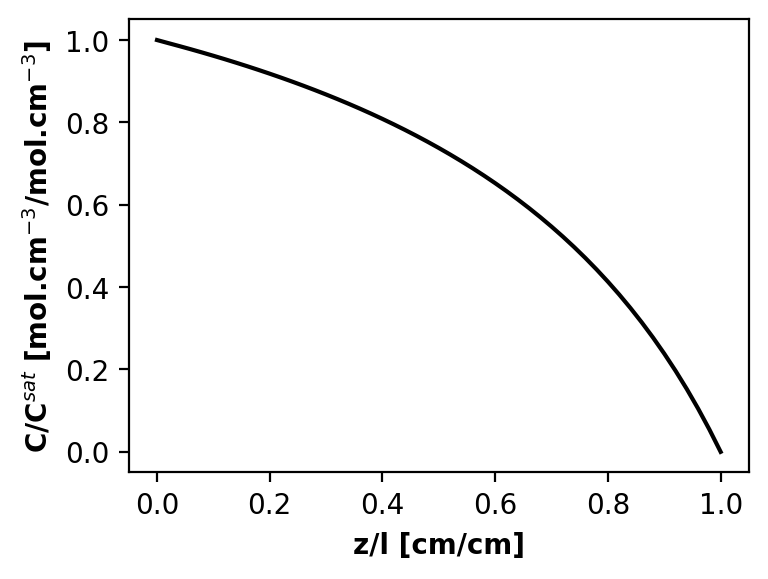

In [ ]:
# extract indices
idx = sorted(m.z)


# configure plot area
fig = plt.figure(figsize=(4,3),dpi=200)
plt.rcParams.update({"font.size":10})
plt.rcParams["axes.labelweight"] = "bold"

### BEGIN SOLUTION ###

# extract concentration values
# create empty containers for height and concentration
z_L1 = [] # normalized z coordinate, z/L
c_csat1 = [] # normalized concentration, C/Csat

# loop over indices
for i in idx:
  # extract height and scale over L
  z_L1.append(i/m.L.value)
  # extract concentration and scale over c_sat
  c_csat1.append(m.c[i].value/m.Csat.value)

# plot concentration profile
plt.plot(z_L1,c_csat1,"k")
plt.xlabel("z/l [cm/cm]")
plt.ylabel("C/C$^{sat}$ [mol.cm$^{-3}$/mol.cm$^{-3}$]")
plt.show() 

### END SOLUTION ###

### 3.2 Matching Numeric Solution with Analytical Solution

We understand from Prof. Phillip's class that the analytical solution for this problem is as given in equation (**6**). 

$$\begin{equation}
\frac{c}{c^{\text{sat}}} = \frac{R_{o}}{(R_{l} - R_{o})}\big[\frac{R_{l}}{(R_{o} + (R_{l} - R_{o})\frac{z}{l})} - 1\big]
\tag{6} \end{equation}
$$

**Home Activity** 

By use of paper and pencil, integrate equation (**4**) to obtain the concentration profile given in equation(**6**). Take the boundary conditions as:
- C = Csat at z=0
- C = 0 at z=l

Turn in your solution  as .pdf file

**Class Activity 4**

Make concentration profiles for both numeric and analytical solutions on the same plot. 

51 [1.0, 0.9932432432432431, 0.9863013698630136, 0.9791666666666665, 0.971830985915493, 0.9642857142857142, 0.9565217391304347, 0.9485294117647058, 0.9402985074626866, 0.9318181818181819, 0.9230769230769231, 0.9140625, 0.9047619047619047, 0.8951612903225805, 0.8852459016393442, 0.8749999999999999, 0.864406779661017, 0.8534482758620688, 0.8421052631578947, 0.8303571428571428, 0.8181818181818181, 0.8055555555555555, 0.7924528301886791, 0.7788461538461537, 0.7647058823529411, 0.75, 0.7346938775510203, 0.71875, 0.7021276595744681, 0.6847826086956521, 0.6666666666666666, 0.6477272727272727, 0.627906976744186, 0.607142857142857, 0.5853658536585364, 0.5625, 0.5384615384615383, 0.513157894736842, 0.48648648648648635, 0.4583333333333332, 0.4285714285714284, 0.39705882352941185, 0.36363636363636365, 0.328125, 0.2903225806451612, 0.24999999999999994, 0.20689655172413784, 0.1607142857142858, 0.11111111111111127, 0.05769230769230782, -0.0]


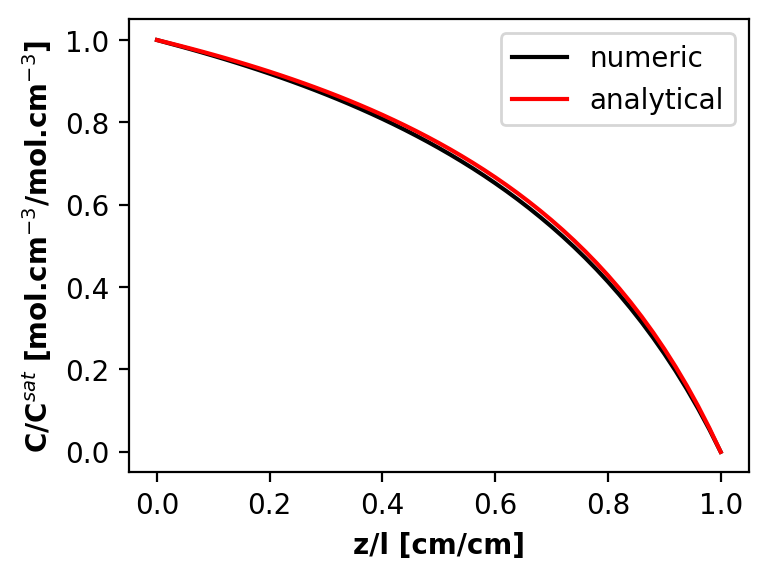

In [ ]:
# compare with analytical solution

### BEGIN SOLUTION ###

# extract indices
idx = sorted(m.z)

# parameters
L = 1.0 # height of conical flask in [cm]
R0 = 0.6 # bottom radius of conical flask in [cm]
Rl = 0.2 # top radius of conical flask in [cm]
Csat = 2.0 # saturated concentration at bottom of flask in [mol/cm3]

# create empty list to hold concentration values
c_csat2 = []

# loop through indices (z coordinate) and calculate concentration values
for z in idx:
  c_csat2.append(R0/(Rl - R0)*(Rl/(R0 + (Rl - R0)*z/L) - 1))
print(len(c_csat2),c_csat2)

# configure plot
fig = plt.figure(figsize=(4,3),dpi=200)
plt.rcParams.update({"font.size":10})
plt.rcParams["axes.labelweight"] = "bold"

# plot concentration profile
plt.plot(z_L1,c_csat1,"k",label='numeric')
plt.plot(z_L1,c_csat2,"r",label='analytical')
plt.xlabel("z/l [cm/cm]")
plt.ylabel("C/C$^{sat}$ [mol.cm$^{-3}$/mol.cm$^{-3}$]")
plt.legend()
plt.show()

### END SOLUTION ###

**Discussion:**

Is there any noticeable deviation between two concentration profiles from analytical and numeric solutions? If yes, what is the cause of the deviation?

### 3.3 Influence of Step-size on Accuracy of Finite-difference Approximations

We shall repeat the numeric integration for different step-sizes in the finite-difference method and plot solutions together with analytical solution.

**Define Function to Create Pyomo Model**

In [ ]:
# define function to create numeric model for ODE in python
def create_model(L=1.0, R0=0.6, Rl=0.2, C_sat=2):
  '''
  Function to create instance of pyomo model for numeric integration of Fick's (second) law

  Arguments:
    L: float, height of conical flask [cm]
    R0: float, bottom radius of conical flask [cm]
    Rl: float, top radius of conical flash [cm]
    c_sat: float, # saturated salt concentration at bottom of flask [mol/cm3]

  return:
    m: concrete pyomo model

  '''
  # create pyomo model
  m = pyo.ConcreteModel()

  # Define model parameters
  m.L = pyo.Param(initialize=L) # height of conical flask [cm]
  m.R0 = pyo.Param(initialize=R0) # bottom radius of conical flask [cm]
  m.Rl = pyo.Param(initialize=Rl) # top radius of conical flash [cm]
  m.c_sat = pyo.Param(initialize=C_sat) # saturated salt concentration at bottom of flask [mol/cm3]


  # Define continuous set for the z coordinate
  m.z = dae.ContinuousSet(bounds=(0,L))

  # Define variables 
  m.c = pyo.Var(m.z)
  m.A = pyo.Var(m.z)

  # Define variables for derivatives
  m.dcdz = dae.DerivativeVar(m.c, wrt=m.z)
  m.dc2dz2 = dae.DerivativeVar(m.c, wrt=(m.z,m.z))
  m.dAdz = dae.DerivativeVar(m.A, wrt=m.z)

  # Define ODE as contraint
  def ode(m,z):
    if z == 0 or z == m.L:
      return pyo.Constraint.Skip
    return m.dAdz[z]*m.dcdz[z] + m.A[z]*m.dc2dz2[z] == 0
  m.ode = pyo.Constraint(m.z,rule=ode)

  # define area
  def area(m,z):
    if z == 0 or z == m.L:
      return pyo.Constraint.Skip
    return m.A[z] == 3.14*(m.R0 + (m.Rl - m.R0)*z/m.L)**2
  m.area = pyo.Constraint(m.z,rule=area)
  
  # Define first boundary condition
  def boundary_condition1(m):
    return m.c[0] == m.c_sat 
  m.bc1 = pyo.Constraint(rule=boundary_condition1)

  # Define second boundary condition
  def boundary_condition2(m):
    return m.c[m.L] == 0 
  m.bc2 = pyo.Constraint(rule=boundary_condition2)

  # Define objective function
  m.obj = pyo.Objective(expr=1)

  return m

**Class Activity 5: Test Function**

Complete the following cell to test the function created above

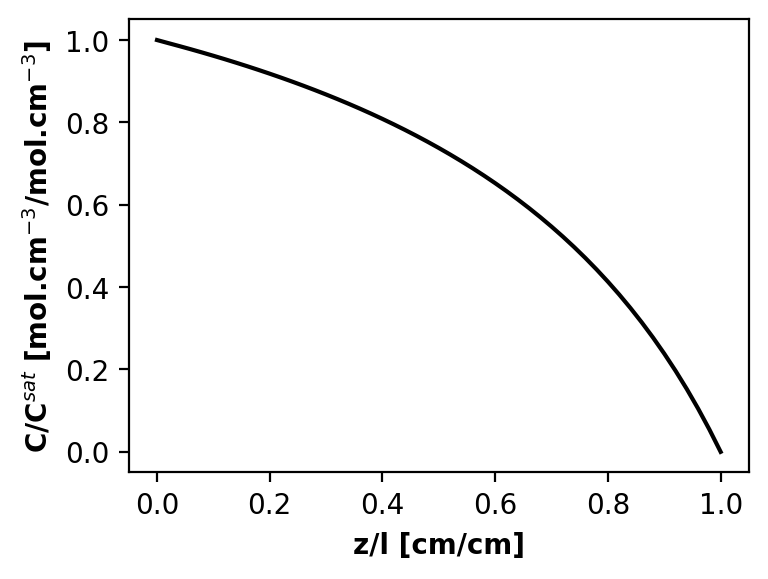

In [ ]:
# create ODE model
m = create_model()

# discritize z
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, scheme='FORWARD', wrt=m.z)

# Solve model
pyo.SolverFactory('ipopt').solve(m,tee=False)

# plot solution. Hint: reuse code from sections above

### BEGIN SOLUTION ###

# extract indices
idx = sorted(m.z)
# extract concentration values
# create empty containers for height and concentration
z_L1 = []
c_csat1 = []
# loop over indices
for i in idx:
  # extract height and scale over L
  z_L1.append(i/m.L.value)
  # extract concentration and scale over c_sat
  c_csat1.append(m.c[i].value/m.c_sat.value)


# configure plot
fig = plt.figure(figsize=(4,3),dpi=200)
plt.rcParams.update({"font.size":10})
plt.rcParams["axes.labelweight"] = "bold"

# plot concentration profile
plt.plot(z_L1,c_csat1,"k")
plt.xlabel("z/l [cm/cm]")
plt.ylabel("C/C$^{sat}$ [mol.cm$^{-3}$/mol.cm$^{-3}$]")
plt.show() 

### END SOLUTION ###

**Class Activity 6**

Begining with the function "create_function" defined above, solve the ODE for different number of finite elements (nfe = 5, 20, 40, 80) and plot concentration profile curves. For each case, label the curve with the corresponding step size. Also plot the analytical solution on this curve. Relative to the analytical solution, describe the accuracy of solution for the various step sizes tried. 

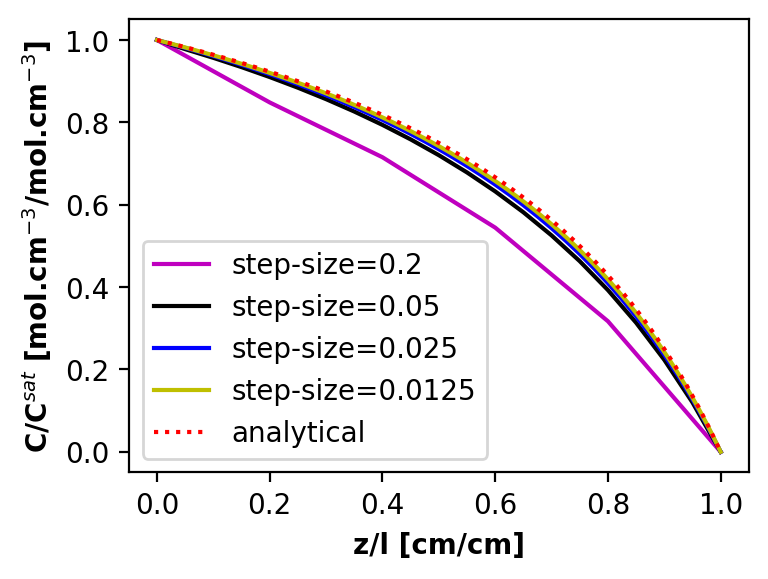

In [ ]:
# make concentration profiles for various step sizes
L = 1.0

# make list of step-sizes
num_element = [5,20,40,80] # list of number of elements
step_size = [] # list of step sizes
# loop through number of elements to calculate step-sizes
for i in num_element:
  step_size.append(L/i)

# configure plotting area
fig = plt.figure(figsize=(4,3),dpi=200)
plt.rcParams.update({"font.size":10})
plt.rcParams["axes.labelweight"] = "bold"
color_list = ['m','k','b','y']

# loop through list of number of elements and step sizes to solve ODE and 
# plot conc profile. Hint: use "enumerate"

### BEGIN SOLUTION ###

for i,num in enumerate(num_element):

  # create instance of ODE model in Pyomo
  m = create_model()

  # discritize z with forward differnce and num_element elements
  pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=num, scheme='FORWARD', wrt=m.z)

  # solve model 
  pyo.SolverFactory('ipopt').solve(m,tee=False)

  # Extract conc values and make concentration profile. Add label as corresponding step size
  idx = sorted(m.z)
  # extract concentration values
  # create empty containers for height and concentration
  z_L = []
  c_csat1 = []
  # loop over indices
  for j in idx:
    # extract height and scale over L
    z_L.append(j/m.L.value)
    # extract concentration and scale over c_sat
    c_csat1.append(m.c[j].value/m.c_sat.value)
  # plot conc profile
  plt.plot(z_L,c_csat1,color=color_list[i],label="step-size={}".format(step_size[i]))

# Add concentration profile from analytical solution. Hint: reuse values from 
# previous cell on on comparison of numeric and analytical solutions
plt.plot(z_L1,c_csat2,"r:",label='analytical')
# decorate plot; x, y labels, etc
plt.xlabel("z/l [cm/cm]")
plt.ylabel("C/C$^{sat}$ [mol.cm$^{-3}$/mol.cm$^{-3}$]")
plt.legend()
plt.show() 

### END SOLUTION ###

**Discussion:** 

In 1-3 sentences discuss any observations from the above plot. Hint: refer to error of Euler method for finite difference approximations ([7.5. Forward and Backward Euler Methods](https://ndcbe.github.io/data-and-computing/notebooks/07/Forward-and-Backward-Euler.html)). Submit solution as .pdf file

### 3.4 Comparison of Different Algorithms for Finite Difference Approximation of Numeric Solutions

**Class Activity 7**

Using a fixed finite elements number of 50, solve the ODE for foward, backward and central difference methods. Makes concentration profiles for these different algorithms together with the analytical solution and discuss your findings. 

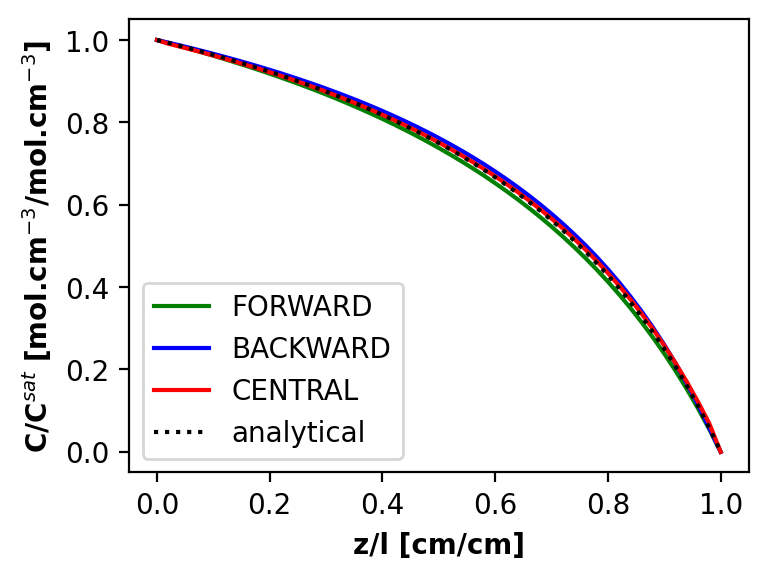

In [ ]:
# list of finite different methods
method_list = ["FORWARD","BACKWARD","CENTRAL"]

# configure plotting area
fig = plt.figure(figsize=(4,3),dpi=200)
plt.rcParams.update({"font.size":10})
plt.rcParams["axes.labelweight"] = "bold"
color_list = ['g','b','r']

# empty container to hold error
error = {}

# loop through method_list and solve ODE
### BEGIN SOLUTION ###
for i, method in enumerate(method_list):
  # create instance of ODE model in Pyomo
  m = create_model()

  # discritize z with forward differnce and num_element elements
  pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, scheme=method, wrt=m.z)

  # solve model 
  pyo.SolverFactory('ipopt').solve(m,tee=False)

  # Extract conc values and make concentration profile. Add label as corresponding step size
  idx = sorted(m.z)
  # extract concentration values
  # create empty containers for height and concentration
  z_L = []
  c_csat1 = []
  # loop over indices
  for j in idx:
    # extract height and scale over L
    z_L.append(j/m.L.value)
    # extract concentration and scale over c_sat
    c_csat1.append(m.c[j].value/m.c_sat.value)
  # plot conc profile
  plt.plot(z_L,c_csat1,color=color_list[i],label=method)

  # estimate error
  error = integration_error(N=len(c_csat1),yapprox=c_csat1,yexact=c_csat2)
  error["".format(method)] = error

# Add concentration profile from analytical solution. Hint: reuse values from 
# previous cell on on comparison of numeric and analytical solutions
plt.plot(z_L1,c_csat2,"k:",label='analytical')
# decorate plot; x, y labels, etc
plt.xlabel("z/l [cm/cm]")
plt.ylabel("C/C$^{sat}$ [mol.cm$^{-3}$/mol.cm$^{-3}$]")
plt.legend()
plt.show() 

print(error)

### END SOLUTION ###

In [ ]:
# define function to estimate error
def integration_error(N,yapprox,yexact):
  '''
  function to estimate integration error
  

  arguments:
    N: int, number of data points
    yapprox: list, approximate solutions rom integration
    yexact: list, exact value

  returns:
    error: float, integration error
  '''

  # estimate error
  error = (1/np.sqrt(N))*sum((yapprox[i] - yexact[i])**2 for i in len(N))

  return error

In [ ]:
# estimate error associated with each method
N = 50

# forward
forward_error = integration_error(N=N,yapprox=)

**Discussion:** In 2-3 sentences, discuss your observations from the plot above. Include (1) which method is more accurate and (2) why is it more accurate. Submit your response in the .pdf file.